In [1]:
import json
import os

from analysis import *
from plot_main import *


In [2]:
exp_dir = '../exp/hierarchical/'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
exp_times = {
    'start_time': 0.0,
    'end_time': 1.0,
    'stim_onset': 0.0,
    'stim_end': 1.0,
    'rwd_onset': 0.8,
    'rwd_end': 1.0,
    'choice_onset': 0.5,
    'choice_end': 0.8,
    'total_time': 1,
    'dt': args['dt']}
log_interval = 1
task_mdprl = MDPRL(exp_times, args['input_type'])
print('loaded task')

loaded args
loaded task


In [3]:
input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

input_unit_group = {
    'feat': [args['stim_dim']*args['stim_val']], 
    'feat+obj': [args['stim_dim']*args['stim_val'], args['stim_val']**args['stim_dim']], 
    'feat+conj+obj': [args['stim_dim']*args['stim_val'], args['stim_dim']*args['stim_val']*args['stim_val'], args['stim_val']**args['stim_dim']]
}[args['input_type']]

if args['attn_type']!='none':
    if args['input_type']=='feat':
        channel_group_size = [args['stim_val']]*args['stim_dim']
    elif args['input_type']=='feat+obj':
        channel_group_size = [args['stim_val']]*args['stim_dim'] + [args['stim_val']**args['stim_dim']]
    elif args['input_type']=='feat+conj+obj':
        channel_group_size = [args['stim_val']]*args['stim_dim'] + [args['stim_val']*args['stim_val']]*args['stim_dim'] + [args['stim_val']**args['stim_dim']]
else:
    channel_group_size = [input_size]

args['output_size'] = 2 if 'double' in args['task_type'] else 1

model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': args['output_size'], 
                'plastic': args['plas_type']=='all', 'attention_type': args['attn_type'], 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 'channel_group_size': channel_group_size,
                'c_plasticity': None, 'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'input_unit_group': input_unit_group, 'sep_lr': args['sep_lr'], 'plastic_feedback': args['plastic_feedback'],
                'value_est': 'policy' in args['task_type'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'spatial_attn_agg': args['spatial_attn_agg'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1), 'input_plastic': not args['input_plas_off']}

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

HierarchicalRNN(
  (rnn): PlasticLeakyRNNCell(
    (x2h): EILinear()
    (aux2h): EILinear()
    (h2h): EILinear()
  )
  (h2o): EILinear()
)
rnn.kappa_rec 25600
rnn.x2h.weight 10080
rnn.aux2h.weight 320
rnn.h2h.weight 25600
rnn.h2h.bias 160
h2o.weight 128
h2o.bias 1
<All keys matched successfully>


In [31]:
n_samples = 1
losses, losses_means, losses_stds, all_saved_states, all_indices, all_probs, all_gen_levels = run_model(args, model, task_mdprl, n_samples)
print('simulation complete')

# stim_probs_ordered = all_probs.reshape(27, 10)[all_indices[:,i,0]]

# selectivity, sort_inds, cluster_label = unit_selectivity(all_saved_states['hs'], np.argmax(stim_probs_ordered, axis=-1), 
#                                                     e_size=int(args['e_prop']*args['hidden_size']))

0
tensor(0.3926) tensor(0.0071)
simulation complete


In [5]:
results = plot_weight_tca(all_saved_states['hs'].numpy().squeeze(), 'rate')

fitting model of rank 3
fitting model of rank 4
fitting model of rank 5
fitting model of rank 6
fitting model of rank 7
fitting model of rank 8
fitting model of rank 9
fitting model of rank 10
fitting model of rank 11
fitting model of rank 12
fitting model of rank 13
fitting model of rank 14
fitting model of rank 15
fitting model of rank 16
fitting model of rank 17
fitting model of rank 18
fitting model of rank 19
fitting model of rank 20


0.5859295576260419
0.5485923304007543
0.5139635472122536
0.4853223663448358
0.45632485739295187
0.4241857261974754
0.38868609283974015
0.3578538789931861
0.33889884852794727
0.3277162755480568
0.29333506575186585
0.28395205814625474
0.2649774113691549
0.22624381596988105
0.1923462842547079
0.1916713233059641
0.16625461763374766
0.16255047841552636


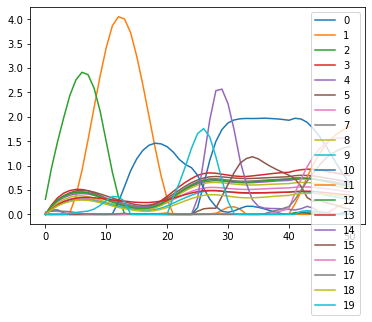

In [6]:
for i in range(3, 20+1):
    print(results[i][0]['errors'][-1])

plt.plot(results[20][0]['cp_tensor'].factors[1], label=range(20))
plt.legend()


In [10]:
# from matplotlib.pyplot import figure


figure(figsize=(20, 16), dpi=300)
fig, axes = plt.subplots(4, 5)
for i in range(20):
    axes[i//5][i%5].bar(range(160), results[20][0]['cp_tensor'].factors[2][sort_inds,i], label=range(20))
# plt.ylim([-1, 1])
# plt.legend()
plt.tight_layout()


NameError: name 'sort_inds' is not defined

In [9]:
%matplotlib qt 

from matplotlib.pyplot import figure
# figure(figsize=(20, 20), dpi=300)
plot_connectivity_lr(torch.cat([torch.argsort(model.h2o.effective_weight().detach().squeeze()), torch.arange(128,160)]), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([model.h2o.effective_weight().detach(), torch.zeros(1, 32)], dim=1),
                             h2ob=state_dict['h2o.bias'].detach(),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size']))

In [32]:
print(all_gen_levels)
print(all_probs.squeeze())
plt.plot(losses_means[0])

['conj']
tensor([0.5299, 0.9578, 0.5163, 0.1927, 0.2210, 0.5034, 0.1927, 0.5299, 0.5034,
        0.1927, 0.5299, 0.5299, 0.5163, 0.1927, 0.2210, 0.1927, 0.2210, 0.5957,
        0.2210, 0.1927, 0.2210, 0.1345, 0.1927, 0.1164, 0.5299, 0.9578, 0.1164,
        0.9578, 0.5299, 0.1164, 0.5957, 0.1345, 0.5299, 0.9578, 0.5163, 0.9578,
        0.2210, 0.2210, 0.1164, 0.1164, 0.1927, 0.5957, 0.1345, 0.5299, 0.9578,
        0.9578, 0.9578, 0.1164, 0.5163, 0.5034, 0.9578, 0.5957, 0.1927, 0.5957,
        0.5299, 0.1164, 0.1164, 0.5163, 0.5163, 0.1345, 0.5034, 0.5957, 0.2210,
        0.2210, 0.5957, 0.1927, 0.5957, 0.1345, 0.5034, 0.5299, 0.9578, 0.5957,
        0.1164, 0.1345, 0.5957, 0.5299, 0.5163, 0.5163, 0.5299, 0.2210, 0.5034,
        0.5957, 0.1927, 0.5034, 0.5299, 0.1927, 0.5299, 0.9578, 0.1345, 0.5299,
        0.1345, 0.5034, 0.5957, 0.5034, 0.9578, 0.1164, 0.5957, 0.1164, 0.2210,
        0.9578, 0.1345, 0.1927, 0.5163, 0.5034, 0.5163, 0.2210, 0.1345, 0.5163,
        0.1164, 0.5957, 0.1164,

In [55]:
fig = plt.figure()
sort_inds = torch.cat([torch.argsort(model.h2o.effective_weight().detach().squeeze()), torch.arange(128,160)])
for i in range(10):
    # plt.subplot(1, 5, i+1).imshow((model.rnn.h2h.effective_weight(all_saved_states['whs'][i*2*26,-1,0]).squeeze().detach()-model.rnn.h2h.effective_weight().detach())[sort_inds][:,sort_inds], interpolation='nearest', vmin=-0.3, vmax=0.3, cmap='seismic')
    plt.subplot(1, 10, i+1).imshow(all_saved_states['hs'][3+i*26,:,0].squeeze().T, aspect='auto');
    # plt.ylim([-0.05, 1])
plt.tight_layout()

torch.Size([1, 160, 160])